Installation of all the requirements.

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install torch

Here we import the training data

In [2]:
import pandas as pd
from transformers import CamembertTokenizer
from sklearn.model_selection import train_test_split

# Load the data
train_data = pd.read_csv('https://raw.githubusercontent.com/ROULIND/DSML-Apple-Project-difficulty-analysis/main/1_DATA/1_0_PROJECT_DATA/training_data.csv')

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    train_data['sentence'],
    train_data['difficulty'],
    test_size=0.2,
    random_state=42
)

# Initialize the tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Tokenize the data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

# Map difficulty levels to numeric values
difficulty_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
train_labels = train_labels.replace(difficulty_mapping)
test_labels = test_labels.replace(difficulty_mapping)

print(len(train_encodings['input_ids']), len(train_labels))

train_labels = train_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)


sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


3840 3840


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class FrenchSentencesDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Ensure idx is a valid index
        if idx >= len(self):
            raise IndexError(f"Index {idx} is out of bounds")

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = FrenchSentencesDataset(train_encodings, train_labels)
test_dataset = FrenchSentencesDataset(test_encodings, test_labels)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [10]:
from transformers import CamembertForSequenceClassification

model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=6)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(6):  # Adjust the number of epochs
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total

train_accuracy = evaluate(model, train_loader)
test_accuracy = evaluate(model, test_loader)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")




Training Accuracy: 0.9589583333333334
Testing Accuracy: 0.9520833333333333


Training Accuracy: 0.9589583333333334
Training Precision: 0.959225961099395
Training Recall: 0.9589583333333334
Training F1-Score: 0.958845611981464
Testing Accuracy: 0.9520833333333333
Testing Precision: 0.9522928878978597
Testing Recall: 0.9520833333333333
Testing F1-Score: 0.9518997056588266


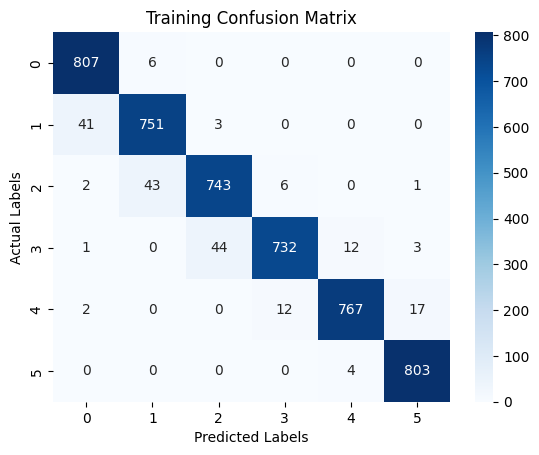

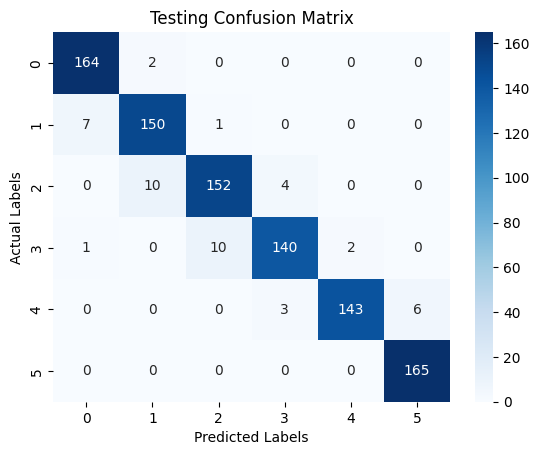

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, data_loader):
    model.eval()
    predictions_list = []
    true_labels_list = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            predictions_list.extend(predictions.cpu().numpy())
            true_labels_list.extend(labels.cpu().numpy())

    # Calculate metrics using sklearn
    accuracy = accuracy_score(true_labels_list, predictions_list)
    precision = precision_score(true_labels_list, predictions_list, average='weighted')
    recall = recall_score(true_labels_list, predictions_list, average='weighted')
    f1 = f1_score(true_labels_list, predictions_list, average='weighted')
    cm = confusion_matrix(true_labels_list, predictions_list)

    return accuracy, precision, recall, f1, cm

# Evaluate on train and test sets
train_accuracy, train_precision, train_recall, train_f1, train_cm = evaluate(model, train_loader)
test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate(model, test_loader)

# Print the performance metrics
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Precision: {train_precision}")
print(f"Training Recall: {train_recall}")
print(f"Training F1-Score: {train_f1}")

print(f"Testing Accuracy: {test_accuracy}")
print(f"Testing Precision: {test_precision}")
print(f"Testing Recall: {test_recall}")
print(f"Testing F1-Score: {test_f1}")

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(train_cm, title='Training Confusion Matrix')
plot_confusion_matrix(test_cm, title='Testing Confusion Matrix')


## Retraining on the full training dataset


In [8]:
# Load the data
train_data = pd.read_csv('https://raw.githubusercontent.com/ROULIND/DSML-Apple-Project-difficulty-analysis/main/1_DATA/1_0_PROJECT_DATA/training_data.csv')

# Map difficulty levels to numeric values
difficulty_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
train_labels = train_data['difficulty'].replace(difficulty_mapping)

# Initialize the tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Tokenize the data
train_encodings = tokenizer(train_data['sentence'].tolist(), truncation=True, padding=True, max_length=128)

# Reset index of train_labels if needed
train_labels = train_labels.reset_index(drop=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
class FrenchSentencesDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset
full_dataset = FrenchSentencesDataset(train_encodings, train_labels)

# Create dataloader
full_loader = DataLoader(full_dataset, batch_size=16, shuffle=True)

In [ ]:
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=6)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(20):  # Adjust the number of epochs as needed
    model.train()
    for batch in full_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
model.save_pretrained('./camembert_full_model')

In [ ]:
# Load unlabelled data
unlabelled_data = pd.read_csv('https://raw.githubusercontent.com/ROULIND/DSML-Apple-Project-difficulty-analysis/main/1_DATA/1_0_PROJECT_DATA/unlabelled_test_data.csv')

# Tokenize the unlabelled data
unlabelled_encodings = tokenizer(unlabelled_data['sentence'].tolist(), truncation=True, padding=True, max_length=128)

# Create a Dataset for unlabelled data
class UnlabelledDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

unlabelled_dataset = UnlabelledDataset(unlabelled_encodings)
unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=16, shuffle=False)


In [ ]:
model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    for batch in unlabelled_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())

# Map numeric predictions back to difficulty labels
inverse_difficulty_mapping = {v: k for k, v in difficulty_mapping.items()}
predicted_labels = [inverse_difficulty_mapping[pred] for pred in predictions]

In [ ]:
result_df = pd.DataFrame({
    'id': range(1, len(predicted_labels) + 1),  # Generating a sequence of IDs starting from 1
    'sentence': unlabelled_data['sentence'],
    'difficulty': predicted_labels
})

result_df.head(100)

In [ ]:
from google.colab import files
# Create DataFrame with only predicted difficulties
result_df = pd.DataFrame({
    'id': range(0, len(predicted_labels)),  # Generating a sequence of IDs starting from 1
    'difficulty': predicted_labels
})


# Export to CSV
result_df.to_csv('predicted_difficulties_only.csv', index=False)
files.download('predicted_difficulties_only.csv')